<a href="https://colab.research.google.com/github/connected-bsamadi/colab-notebooks/blob/master/Stack_Overflow_Reputation_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow Reputation - Linear Regression

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import seaborn as sns 

%matplotlib inline

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from google.cloud import bigquery

project_id = 'ontario-2018'
client = bigquery.Client(project=project_id)

## Ingest

In [0]:
# Number of people
n=10000

In [0]:
query = ('''
WITH
  g AS (
  SELECT
    author.name AS name,
    COUNT(commit) AS num_commits,
    COUNT(DISTINCT repo_name) AS num_repos,
    AVG(LENGTH(subject)) AS avg_subject_len,
    AVG(LENGTH(message)) AS avg_message_len,
    AVG(author.time_sec) AS avg_time,
    COALESCE(STDDEV(author.time_sec),
      0) AS std_time
  FROM
    `bigquery-public-data.github_repos.sample_commits`
  GROUP BY
    author.name),
  s AS (
  SELECT
    display_name,
    AVG(reputation) AS reputation,
    AVG(up_votes) AS up_votes,
    AVG(down_votes) AS down_votes,
    AVG(views) AS views
  FROM
    `bigquery-public-data.stackoverflow.users`
  GROUP BY
    display_name )
SELECT
  name,
  num_commits,
  num_repos,
  avg_subject_len,
  avg_message_len,
  avg_time,
  std_time,
  reputation,
  up_votes,
  down_votes,
  views
FROM
  g
INNER JOIN
  s
ON
  g.name=s.display_name
LIMIT 
'''+str(n))
job_config = bigquery.job.QueryJobConfig()
query_job = client.query(query,job_config)

In [7]:
df = query_job.to_dataframe()
df.head()

,name,num_commits,num_repos,avg_subject_len,avg_message_len,avg_time,std_time,reputation,up_votes,down_votes,views
0,Matthew Leffler,1,1,4.0,4.0,1.376438e+09,0.0,602.500000,913.500000,1.000000,62.000000
1,Nathan Howell,1,1,8.0,9.0,1.451933e+09,0.0,1348.333333,20.333333,2.333333,135.000000
2,Tushar,1,1,8.0,8.0,1.450034e+09,0.0,317.835913,13.597523,26.065015,57.678019
3,naoyashiga,1,1,8.0,9.0,1.457097e+09,0.0,8.000000,0.000000,0.000000,26.000000
4,Steve Moser,1,1,9.0,9.0,1.449166e+09,0.0,4081.000000,1373.000000,6.000000,600.000000


## Validate

In [8]:
df.isnull().sum()

name               0
num_commits        0
num_repos          0
avg_subject_len    0
avg_message_len    0
avg_time           0
std_time           0
reputation         0
up_votes           0
down_votes         0
views              0
dtype: int64

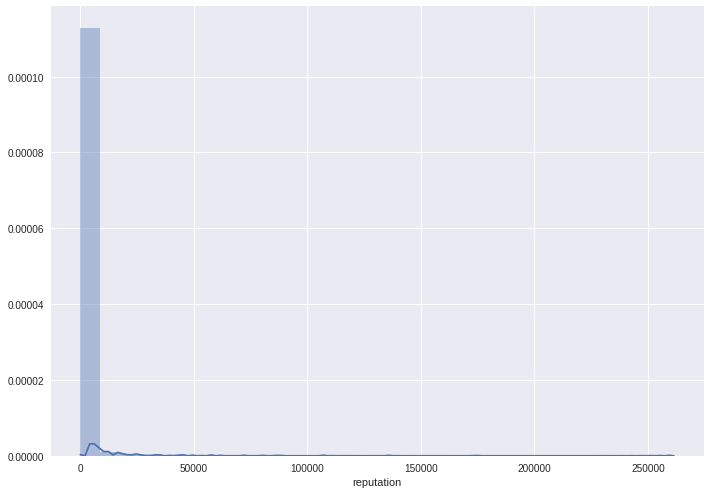

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['reputation'], bins=30)
plt.show()

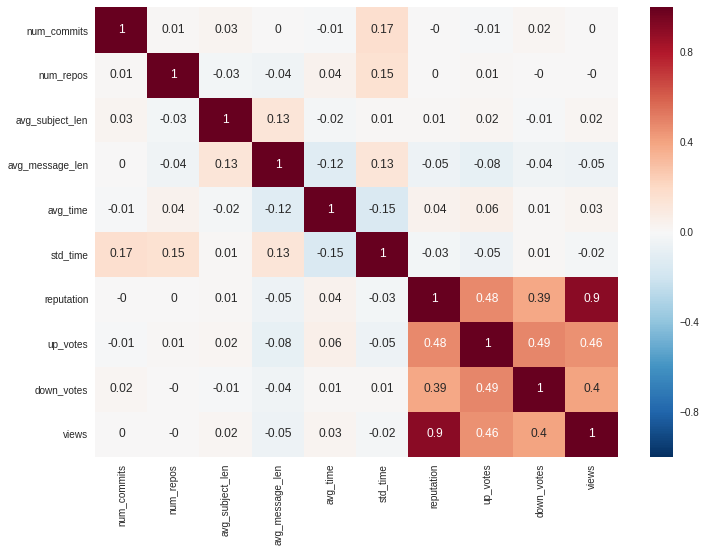

In [10]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [11]:
df.reputation.max()

261410.5

In [12]:
df.reputation.min()

1.0

In [13]:
df.reputation.mean()

763.1608219547252

## Transform

In [0]:
X = pd.DataFrame(df,columns=['num_commits','num_repos','avg_subject_len', 'avg_message_len', 'avg_time', 'up_votes', 'down_votes', 'views'])
Y = df['reputation']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4150, 8)
(1038, 8)
(4150,)
(1038,)


## Build Model

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_model = LinearRegression()

## Train

In [17]:
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Evaluate

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 2903.787784712639
R2 score is 0.6851075094918555


The model performance for testing set
--------------------------------------
RMSE is 1608.177045660366
R2 score is 0.9702706143412759


## Validate

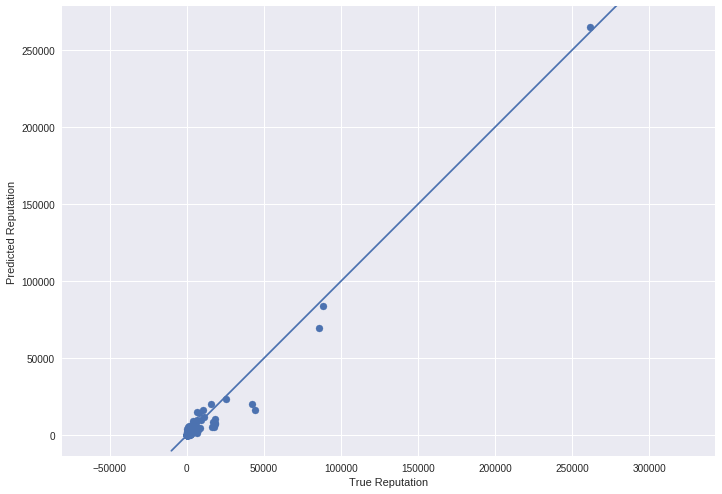

In [19]:
plt.scatter(Y_test, y_test_predict)
plt.xlabel('True Reputation')
plt.ylabel('Predicted Reputation')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-10000, 350000], [-10000, 350000])

## Push

## Serve